In [85]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import matplotlib.cm as cm
import os, sys
from PIL import Image
import gc
import time
import math
import numpy as np
import numpy.ma as ma
import matplotlib
from scipy.stats import lognorm
from astropy.io import fits
from scipy.stats import mode
import time
import ast
import matplotlib.pyplot as plt
import math
import fnmatch as fnm
from scipy.optimize import curve_fit
from scipy.stats import chisquare
from scipy.signal import find_peaks
from scipy.io import readsav
import csv
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import LimbSpectralTool_getL1CData_v20 as gsi_l1c
import LimbSpectralTool_InteractiveTool_DN_v20 as spectralTool
from matplotlib.widgets import TextBox
import matplotlib.patches as patches
from collections import OrderedDict
from scipy import interpolate
import matplotlib.image as image
import matplotlib.cbook as cbook
import matplotlib.colors as colors
from scipy import stats
import warnings
plt.rcParams.update({'figure.max_open_warning': 0})
warnings.filterwarnings("ignore")

In [86]:
version = 'v20'

In [87]:
#Directory where magnetic field map ('bfield_smoothed.npy') and spectral templates are stored ('templates_.....npy')

#ADRIENNE DIR
map_and_data_dir = r'C:\Users\Owner\OneDrive - UCB-O365\Documents\College\LASP\MAVEN\code\l1c_Adrienne_v20_final\maps_and_data_dir' #UPDATE FOR EACH NEW SYSTEM

#BEN DIR
#map_and_data_dir = r'C:\Users\benja\Documents\l1c_adrienne_20Jan2022\maps\maps_and_data_dir'


map_img = np.load(map_and_data_dir+'\\magneticFieldMaps\\bfield_smoothed.npy') 
templates512 = np.load(map_and_data_dir+'\\DN_templates\\templates_512_DN.npy', allow_pickle=True)
templates256 = np.load(map_and_data_dir+'\\DN_templates\\templates_256_DN.npy', allow_pickle=True)

#set colorbar for magnetic field map
mag_cmap = plt.get_cmap('Blues')
mag_cmap.set_bad((1, 1, 1))

#Directory where L1C files are stored
#dir_to_dataFiles = r'C:\Users\Owner\OneDrive - UCB-O365\Documents\College\LASP\MAVEN\code\l1c_Adrienne_v20_final\l1c_files' #UPDATE FOR EACH NEW SYSTEM

In [88]:
#set colorbar for magnetic field map
mag_cmap = plt.get_cmap('Blues')
mag_cmap.set_bad((1, 1, 1))

wav_tmpl256 = templates256.item()['wavelength']
co_tmpl256 = templates256.item()['co_cameron']
uvd_tmpl256 = templates256.item()['co2p_uvd']           
no_tmpl256 = templates256.item()['no_nightglow']
wav_tmpl512 = templates512.item()['wavelength']
co_tmpl512 = templates512.item()['co_cameron']
uvd_tmpl512 = templates512.item()['co2p_uvd']           
no_tmpl512 = templates512.item()['no_nightglow']

In [89]:
def plot_spectrum_in_DN_with_templates(wav_DN, spec_DN, orb, scan, Pr):
    if wav_DN.shape == (364,):
        #use 512 bins
        wav_tmpl_DN, co_tmpl_DN, uvd_tmpl_DN = wav_tmpl512, co_tmpl512, uvd_tmpl512
    else:
        #use 256 bins
        wav_tmpl_DN, co_tmpl_DN, uvd_tmpl_DN = wav_tmpl256, co_tmpl256, uvd_tmpl256
    #DN/nm PLOT
    plt.figure(figsize=(12, 3))
    plt.plot(wav_DN, spec_DN, '--o', c='k', markersize=3.5)
    plt.xlabel("wavelength [nm]")
    plt.xlim(right=325)
    plt.title(f'l1c orbit {orb} scan {scan}, P. r (CO, UVD) = {Pr}')
    maxCO = np.nanmax(spec_DN[:np.where(wav_DN <= 250)[0][-1]])
    maxUVD = np.nanmax(spec_DN[np.where(wav_DN >= 275)[0][0]:np.where(wav_DN <= 300)[0][-1]])
    plt.xlim(np.nanmin(wav_DN), np.nanmax(wav_DN))                  
    plt.plot(wav_tmpl_DN, co_tmpl_DN*maxCO + uvd_tmpl_DN*maxCO, color='purple', alpha=0.7)
    plt.ylabel('DN/nm')
    plt.show()

In [90]:
#ADRIENNE DIR
dirToOld_l1c = r'C:\Users\Owner\OneDrive - UCB-O365\Documents\College\LASP\MAVEN\code\l1c_Adrienne_v20_final\npy_v17Old' #UPDATE FOR EACH NEW SYSTEM
dirtonew = r'C:\Users\Owner\OneDrive - UCB-O365\Documents\College\LASP\MAVEN\code\l1c_Adrienne_v20_final\npy_v20_new'

#BEN DIR
#dirToOld_l1c = r'C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v17Old' 
#dirtonew = r'C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v20_new'

In [91]:
#Load the old v17 and new v20 data files
pixelDataFiles_v17 = gsi_l1c.find_all('*limb_analysis_v17_orbit_*', dirToOld_l1c)
pixelDataFiles_v20 = gsi_l1c.find_all('*limb_analysis_v20_orbit_*', dirtonew)

In [92]:
len(pixelDataFiles_v17)+len(pixelDataFiles_v20)

64

In [93]:
#Get data for old file type
old_DN_spectra, old_DN_wave, old_orbits, old_scans, old_pearsonRs, old_ratios= [], [], [], [], [],[]
for i in range(len(pixelDataFiles_v17)):
    data = np.load(pixelDataFiles_v17[i], allow_pickle=True)

    orbit, scan = int(np.array(data[10])[0]), int(np.array(data[10])[1]) # orbit and scan of interest
    wavArr = np.array(data[0], dtype=np.float64) # wavelength values #nm
    spectrum_kR = np.array(data[1], dtype=np.float64) # spectrum values of clicked pixels, kR/nm
    comlr = np.array(data[8],dtype=np.float64)
    uvdmlr = np.array(data[9],dtype=np.float64)
    old_ratios.append(np.mean(comlr)/np.mean(uvdmlr))
    
    calCurve = gsi_l1c.calibrationCurve(wavArr) #DN/kR
    spectrum_DN = spectrum_kR*calCurve #DN/nm
    
        
    conditionFinite = np.where(np.isfinite(spectrum_DN) == True)[0] #Get rid of nan values for ease of plotting purposes
    wave = wavArr[conditionFinite]
    spectrum_DN = spectrum_DN[conditionFinite]
    old_DN_spectra.append(spectrum_DN)
    old_DN_wave.append(wave)
    old_orbits.append(orbit)
    old_scans.append(scan)
    
    if wave.shape == (364,):
        #use 512 bins
        wav_tmpl0, co_tmpl0, uvd_tmpl0 = wav_tmpl512, co_tmpl512, uvd_tmpl512
    else:
        #use 256 bins
        wav_tmpl0, co_tmpl0, uvd_tmpl0 = wav_tmpl256, co_tmpl256, uvd_tmpl256
    
    summedSpectrumMax_DN = np.nanmax(spectrum_DN[:np.where(wave <= 250)[0][-1]])
    co_tmpl_moved_DN = co_tmpl0*summedSpectrumMax_DN
    uvd_tmpl_moved_DN = uvd_tmpl0*summedSpectrumMax_DN
    
    minWavCO, maxWavCO = 185, 255
    conditionDNleftCO, conditionDNrightCO = np.where(wave <= minWavCO)[0][-1], np.where(wave <= maxWavCO)[0][-1]
    conditionTmplLeftCO, conditionTmplRightCO = np.where(wav_tmpl0 <= minWavCO)[0][-1], np.where(wav_tmpl0 <= maxWavCO)[0][-1]
    tempCO_pearson = co_tmpl_moved_DN[conditionTmplLeftCO:conditionTmplRightCO]
    specCO_pearson = spectrum_DN[conditionDNleftCO:conditionDNrightCO]
    #print(tempCO_pearson.shape, wave.shape)
    specLenCO = len(specCO_pearson)
    tmplLenCO = len(tempCO_pearson)
    if abs(tmplLenCO - specLenCO) == 2 and specLenCO < tmplLenCO:
        tempCO_pearson = tempCO_pearson[1:-1]
    if abs(tmplLenCO - specLenCO) == 2 and specLenCO > tmplLenCO:
        specCO_pearson = specCO_pearson[1:-1]
    if abs(tmplLenCO - specLenCO) == 1 and specLenCO < tmplLenCO:
        tempCO_pearson = tempCO_pearson[:-1]
    if abs(tmplLenCO - specLenCO) == 1 and specLenCO > tmplLenCO:
        specCO_pearson = specCO_pearson[:-1]
    rCO, p = stats.pearsonr(tempCO_pearson, specCO_pearson)
    r_co = round(rCO, 2)

    #uvd pearson-r
    minWavUVD, maxWavUVD = 270, 300
    conditionDNleftUVD, conditionDNrightUVD = np.where(wave <= minWavUVD)[0][-1], np.where(wave <= maxWavUVD)[0][-1]
    conditionTmplLeftUVD, conditionTmplRightUVD = np.where(wav_tmpl0 <= minWavUVD)[0][-1], np.where(wav_tmpl0 <= maxWavUVD)[0][-1]
    tempUVD_pearson = uvd_tmpl_moved_DN[conditionTmplLeftUVD:conditionTmplRightUVD]
    specUVD_pearson = spectrum_DN[conditionDNleftUVD:conditionDNrightUVD]
    specLenUVD = len(specUVD_pearson)
    tmplLenUVD = len(tempUVD_pearson)
    if abs(tmplLenUVD - specLenUVD) == 2 and specLenUVD < tmplLenUVD:
        tempUVD_pearson = tempUVD_pearson[1:-1]
    if abs(tmplLenUVD - specLenUVD) == 2 and specLenUVD > tmplLenUVD:
        specUVD_pearson = specUVD_pearson[1:-1]
    if abs(tmplLenUVD - specLenUVD) == 1 and specLenUVD < tmplLenUVD:
        tempUVD_pearson = tempUVD_pearson[:-1]
    if abs(tmplLenUVD - specLenUVD) == 1 and specLenUVD > tmplLenUVD:
        specUVD_pearson = specUVD_pearson[:-1]
    rUVD, p = stats.pearsonr(tempUVD_pearson, specUVD_pearson)
    r_uvd = round(rUVD, 2)
    
    old_pearsonRs.append((r_co, r_uvd))

In [94]:
v20_DN_spectra, v20_DN_wave, v20_orbits, v20_scans, v20_pearsonRs, v20_ratios = [], [], [], [], [],[]
for i in range(len(pixelDataFiles_v20)):
    data = np.load(pixelDataFiles_v20[i], allow_pickle=True)

    orbit, scan = int(np.array(data[12])[0]), int(np.array(data[12])[1]) # orbit and scan of interest
    wavArr = np.array(data[0], dtype=np.float64) # wavelength values #nm
    spectrum_DN = np.array(data[3], dtype=np.float64) # spectrum values of clicked pixels, kR/nm
    comlr = np.array(data[10],dtype=np.float64)
    uvdmlr = np.array(data[11],dtype=np.float64)
    v20_ratios.append(np.mean(comlr)/np.mean(uvdmlr))
        
    conditionFinite = np.where(np.isfinite(spectrum_DN) == True)[0] #Get rid of nan values for ease of plotting purposes
    wave = wavArr[conditionFinite]
    spectrum_DN = spectrum_DN[conditionFinite]
    v20_DN_spectra.append(spectrum_DN)
    v20_DN_wave.append(wave)
    v20_orbits.append(orbit)
    v20_scans.append(scan)
    
    if wave.shape > (256,):
        #use 512 bins
        wav_tmpl0, co_tmpl0, uvd_tmpl0 = wav_tmpl512, co_tmpl512, uvd_tmpl512
    
    if wave.shape <= (256,):
        #use 256 bins
        wav_tmpl0, co_tmpl0, uvd_tmpl0 = wav_tmpl256, co_tmpl256, uvd_tmpl256
    
    summedSpectrumMax_DN = np.nanmax(spectrum_DN[:np.where(wave <= 250)[0][-1]])
    co_tmpl_moved_DN = co_tmpl0*summedSpectrumMax_DN
    uvd_tmpl_moved_DN = uvd_tmpl0*summedSpectrumMax_DN
    
    minWavCO, maxWavCO = 185, 255
    conditionDNleftCO, conditionDNrightCO = np.where(wave <= minWavCO)[0][-1], np.where(wave <= maxWavCO)[0][-1]
    conditionTmplLeftCO, conditionTmplRightCO = np.where(wav_tmpl0 <= minWavCO)[0][-1], np.where(wav_tmpl0 <= maxWavCO)[0][-1]
    tempCO_pearson = co_tmpl_moved_DN[conditionTmplLeftCO:conditionTmplRightCO]
    specCO_pearson = spectrum_DN[conditionDNleftCO:conditionDNrightCO]
    #print(tempCO_pearson.shape, wave.shape)
    specLenCO = len(specCO_pearson)
    tmplLenCO = len(tempCO_pearson)
    if abs(tmplLenCO - specLenCO) == 2 and specLenCO < tmplLenCO:
        tempCO_pearson = tempCO_pearson[1:-1]
    if abs(tmplLenCO - specLenCO) == 2 and specLenCO > tmplLenCO:
        specCO_pearson = specCO_pearson[1:-1]
    if abs(tmplLenCO - specLenCO) == 1 and specLenCO < tmplLenCO:
        tempCO_pearson = tempCO_pearson[:-1]
    if abs(tmplLenCO - specLenCO) == 1 and specLenCO > tmplLenCO:
        specCO_pearson = specCO_pearson[:-1]
    
    #print(wave.shape)
    #print(tempCO_pearson.shape, specCO_pearson.shape)
    #print('\n\n')
    
    rCO, p = stats.pearsonr(tempCO_pearson, specCO_pearson)
    r_co = round(rCO, 2)

    #uvd pearson-r
    minWavUVD, maxWavUVD = 270, 300
    conditionDNleftUVD, conditionDNrightUVD = np.where(wave <= minWavUVD)[0][-1], np.where(wave <= maxWavUVD)[0][-1]
    conditionTmplLeftUVD, conditionTmplRightUVD = np.where(wav_tmpl0 <= minWavUVD)[0][-1], np.where(wav_tmpl0 <= maxWavUVD)[0][-1]
    tempUVD_pearson = uvd_tmpl_moved_DN[conditionTmplLeftUVD:conditionTmplRightUVD]
    specUVD_pearson = spectrum_DN[conditionDNleftUVD:conditionDNrightUVD]
    specLenUVD = len(specUVD_pearson)
    tmplLenUVD = len(tempUVD_pearson)
    if abs(tmplLenUVD - specLenUVD) == 2 and specLenUVD < tmplLenUVD:
        tempUVD_pearson = tempUVD_pearson[1:-1]
    if abs(tmplLenUVD - specLenUVD) == 2 and specLenUVD > tmplLenUVD:
        specUVD_pearson = specUVD_pearson[1:-1]
    if abs(tmplLenUVD - specLenUVD) == 1 and specLenUVD < tmplLenUVD:
        tempUVD_pearson = tempUVD_pearson[:-1]
    if abs(tmplLenUVD - specLenUVD) == 1 and specLenUVD > tmplLenUVD:
        specUVD_pearson = specUVD_pearson[:-1]
    rUVD, p = stats.pearsonr(tempUVD_pearson, specUVD_pearson)
    r_uvd = round(rUVD, 2)
    
    v20_pearsonRs.append((r_co, r_uvd))

In [95]:
#add the old v17 and the new v20 lists together.
DN_wave = old_DN_wave + v20_DN_wave
DN_spectra = old_DN_spectra + v20_DN_spectra
orbits = old_orbits + v20_orbits
scans = old_scans + v20_scans
pearsonRs = old_pearsonRs + v20_pearsonRs
ratios = old_ratios + v20_ratios
pixelDataFiles = pixelDataFiles_v17 + pixelDataFiles_v20

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v17Old\limb_analysis_v17_orbit_2512scan_2.npy


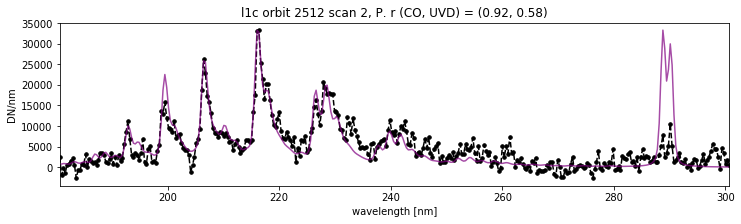

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v17Old\limb_analysis_v17_orbit_2512scan_3.npy


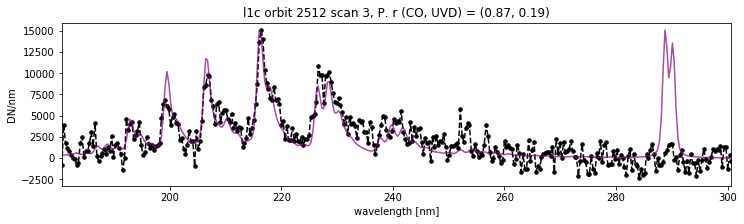

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v17Old\limb_analysis_v17_orbit_2524scan_0.npy


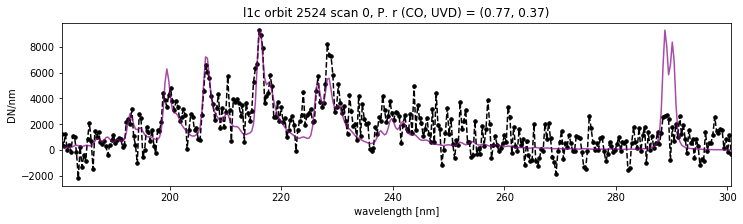

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v17Old\limb_analysis_v17_orbit_2587scan_3.npy


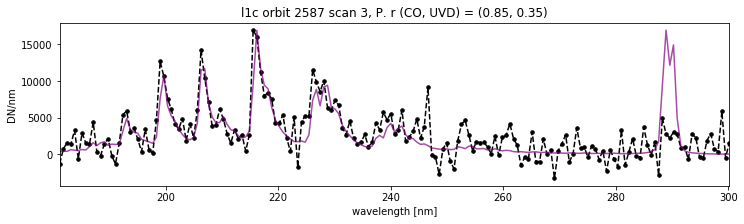

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v17Old\limb_analysis_v17_orbit_2587scan_5.npy


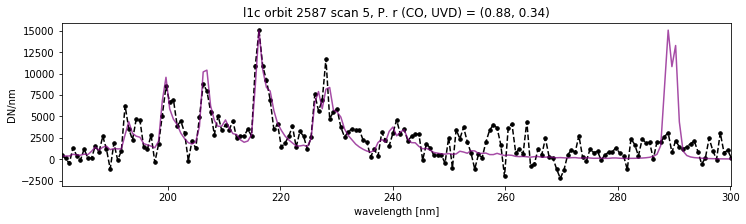

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v17Old\limb_analysis_v17_orbit_2644scan_4.npy


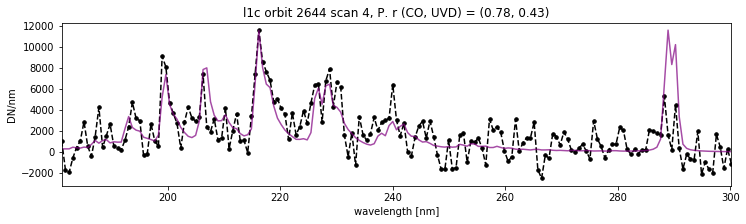

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v17Old\limb_analysis_v17_orbit_2730scan_6.npy


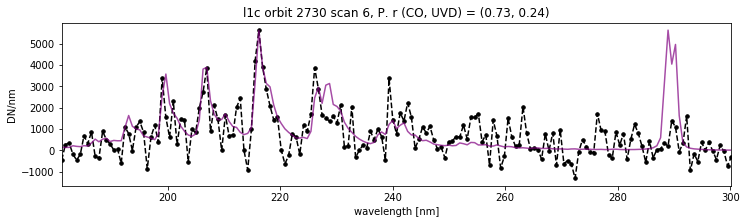

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v17Old\limb_analysis_v17_orbit_3379scan_10.npy


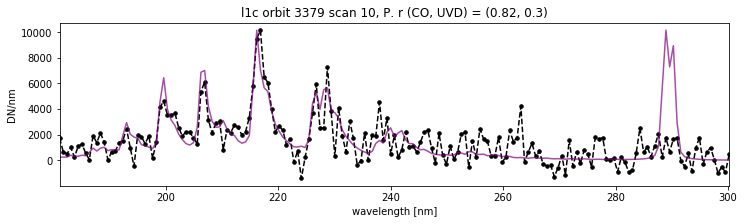

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v17Old\limb_analysis_v17_orbit_3389scan_11.npy


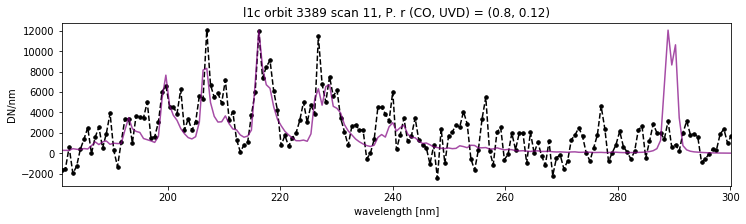

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v17Old\limb_analysis_v17_orbit_3432scan_11.npy


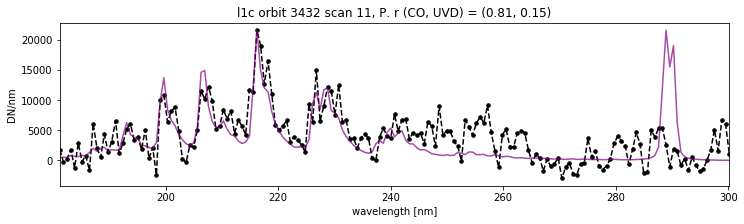

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v17Old\limb_analysis_v17_orbit_3439scan_7.npy


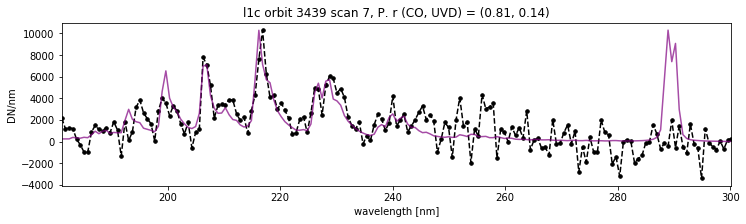

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v17Old\limb_analysis_v17_orbit_3522scan_9.npy


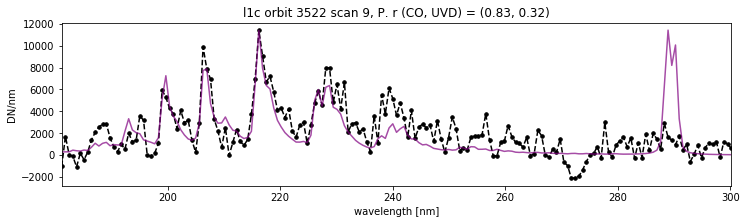

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v17Old\limb_analysis_v17_orbit_3828scan_6.npy


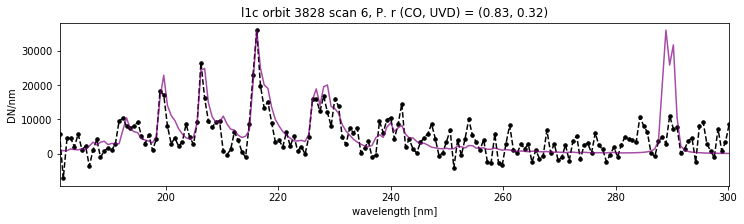

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v17Old\limb_analysis_v17_orbit_3842scan_7.npy


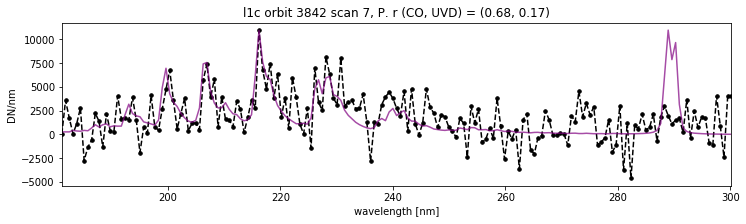

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v17Old\limb_analysis_v17_orbit_3842scan_8.npy


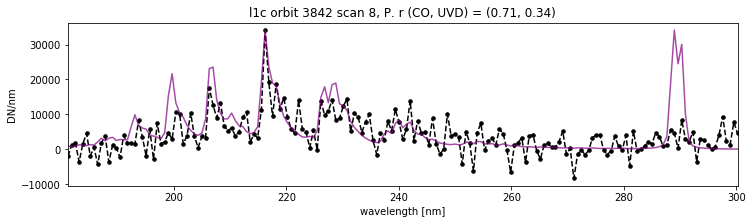

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v17Old\limb_analysis_v17_orbit_3928scan_10.npy


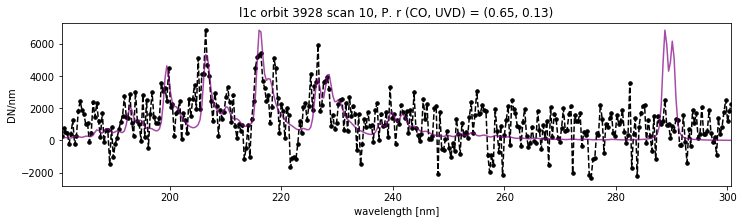

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v17Old\limb_analysis_v17_orbit_401scan_6.npy


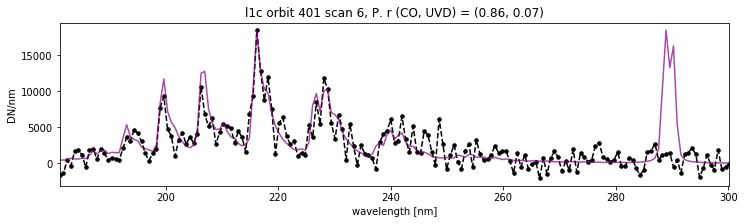

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v17Old\limb_analysis_v17_orbit_401scan_7.npy


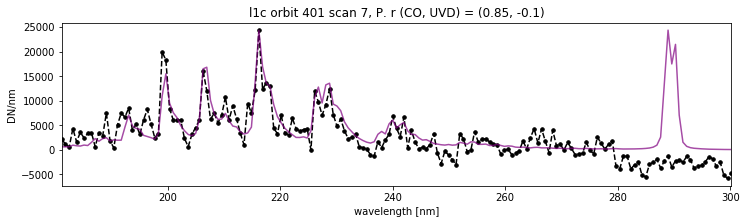

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v17Old\limb_analysis_v17_orbit_405scan_7.npy


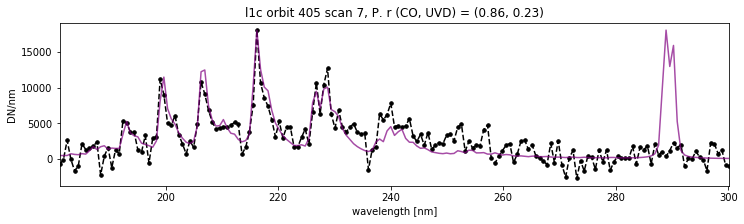

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v17Old\limb_analysis_v17_orbit_408scan_7.npy


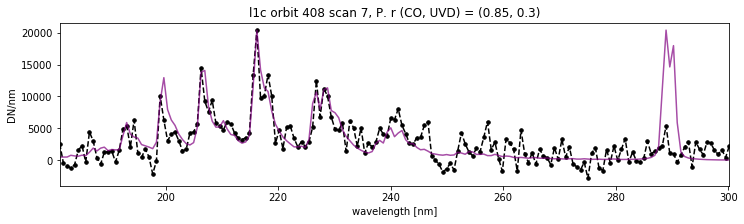

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v17Old\limb_analysis_v17_orbit_416scan_7.npy


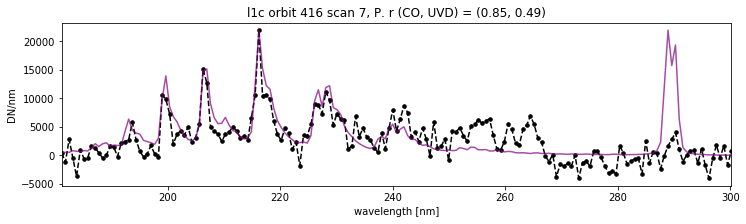

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v17Old\limb_analysis_v17_orbit_426scan_7.npy


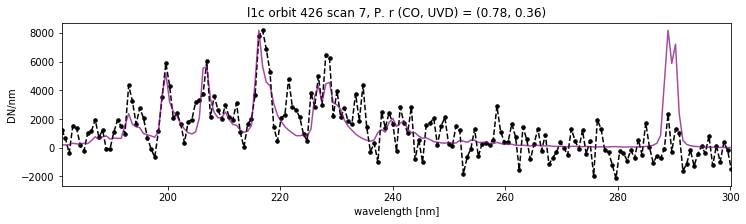

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v17Old\limb_analysis_v17_orbit_426scan_8.npy


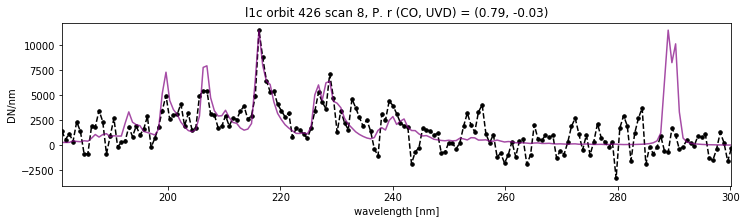

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v17Old\limb_analysis_v17_orbit_4403scan_3.npy


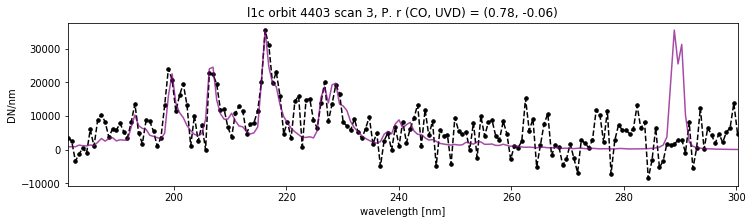

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v17Old\limb_analysis_v17_orbit_4557scan_9.npy


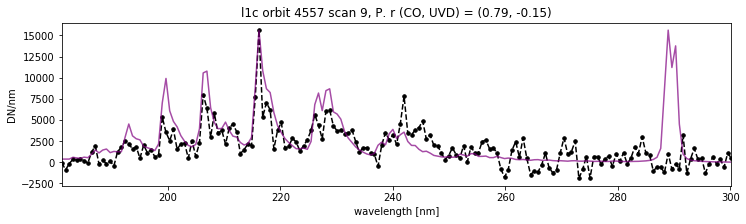

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v17Old\limb_analysis_v17_orbit_4559scan_3.npy


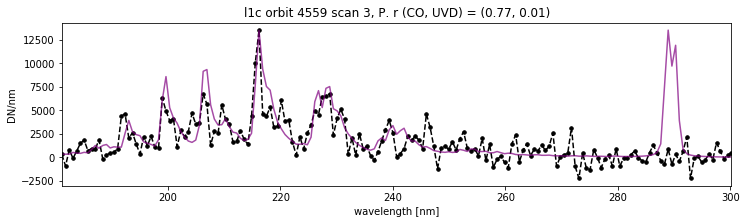

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v17Old\limb_analysis_v17_orbit_4567scan_10.npy


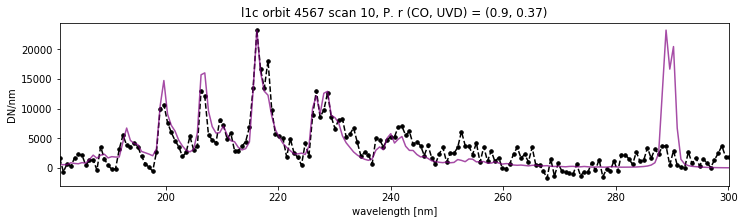

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v17Old\limb_analysis_v17_orbit_4575scan_8.npy


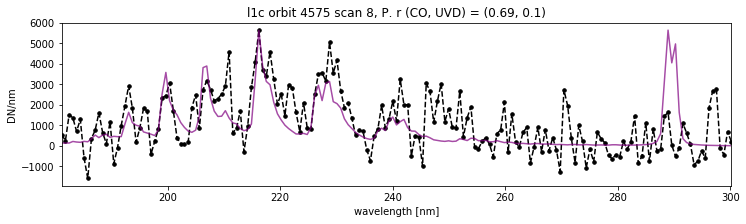

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v17Old\limb_analysis_v17_orbit_4624scan_7.npy


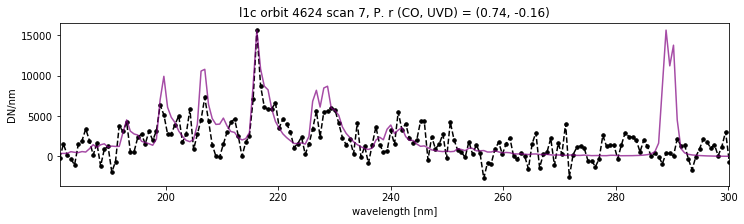

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v17Old\limb_analysis_v17_orbit_4669scan_11.npy


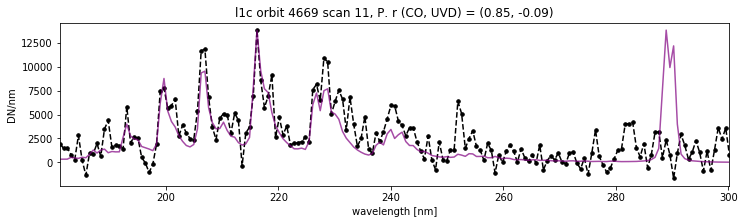

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v17Old\limb_analysis_v17_orbit_4669scan_8.npy


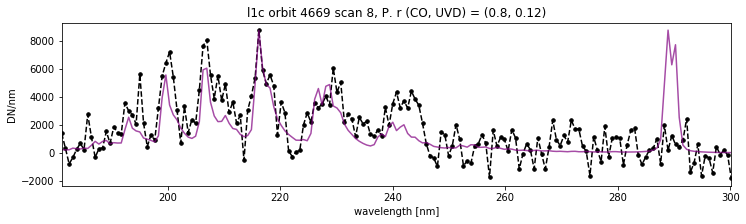

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v17Old\limb_analysis_v17_orbit_4684scan_9.npy


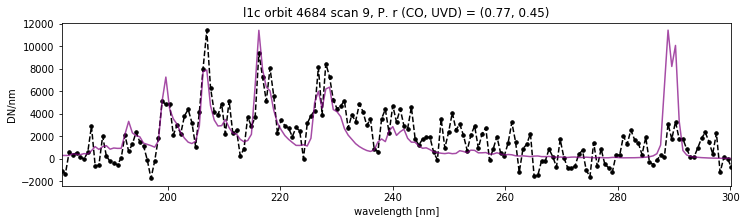

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v17Old\limb_analysis_v17_orbit_4702scan_3.npy


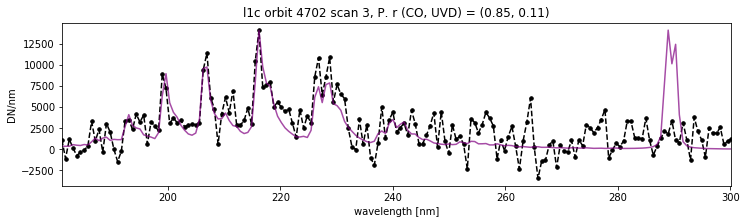

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v17Old\limb_analysis_v17_orbit_4717scan_10.npy


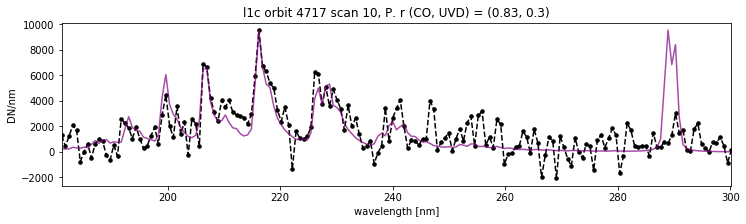

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v17Old\limb_analysis_v17_orbit_6674scan_2.npy


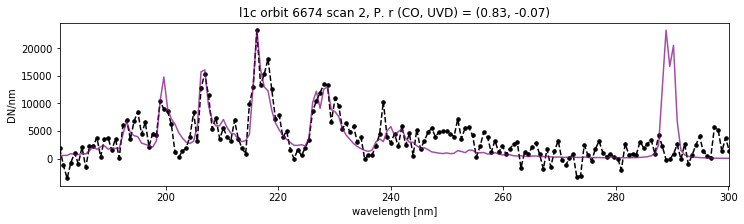

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v17Old\limb_analysis_v17_orbit_6711scan_6.npy


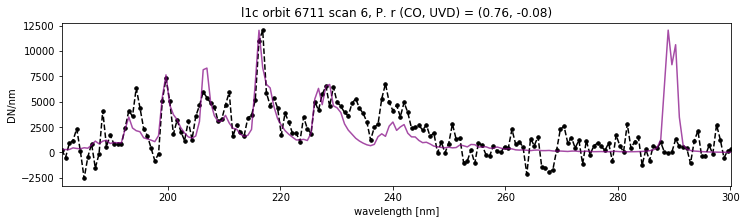

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v17Old\limb_analysis_v17_orbit_6753scan_9.npy


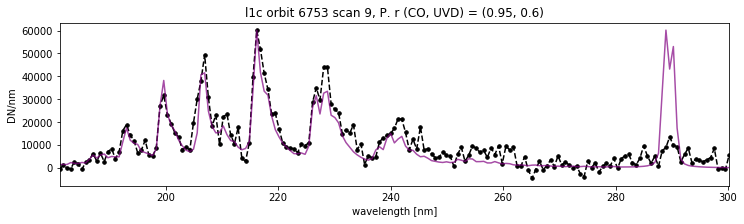

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v17Old\limb_analysis_v17_orbit_6762scan_6.npy


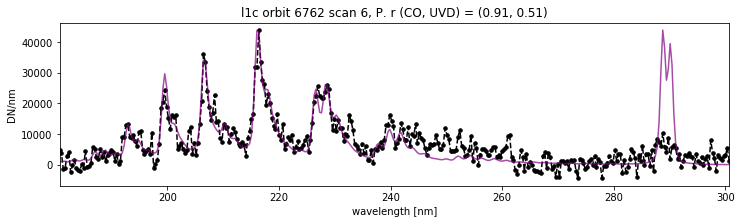

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v17Old\limb_analysis_v17_orbit_7802scan_8.npy


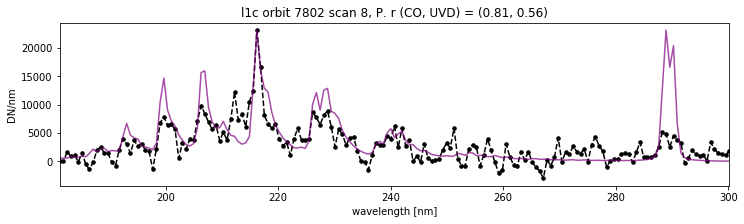

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v17Old\limb_analysis_v17_orbit_7838scan_2.npy


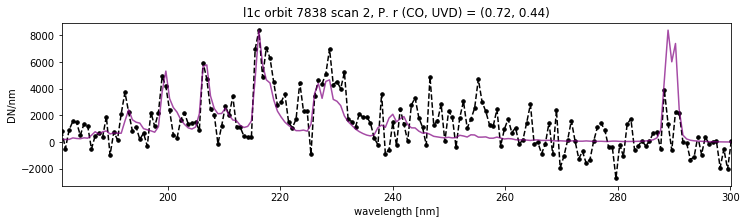

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v17Old\limb_analysis_v17_orbit_7876scan_3.npy


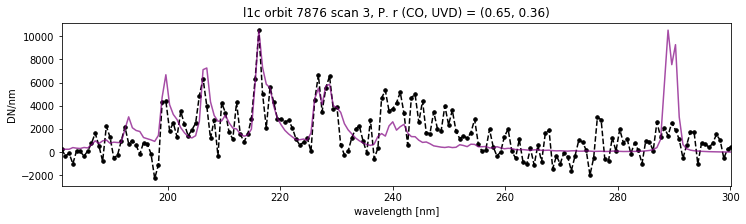

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v17Old\limb_analysis_v17_orbit_7970scan_2.npy


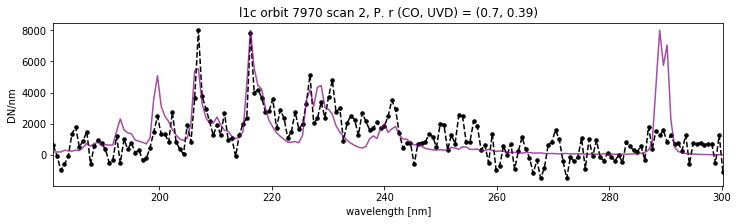

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v17Old\limb_analysis_v17_orbit_8001scan_6.npy


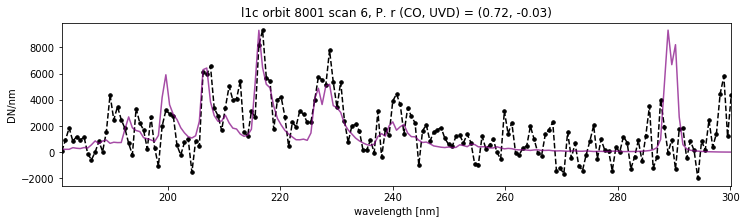

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v17Old\limb_analysis_v17_orbit_8018scan_6.npy


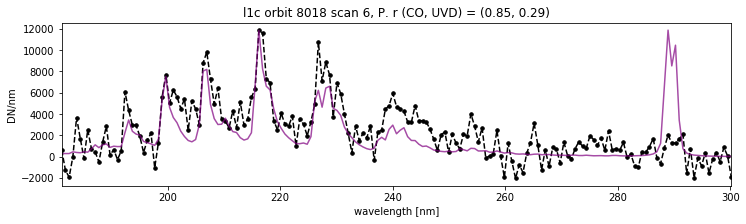

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v17Old\limb_analysis_v17_orbit_8057scan_4.npy


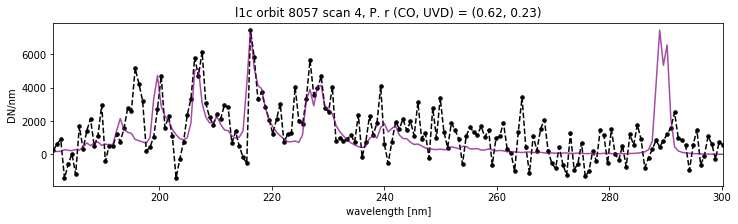

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v17Old\limb_analysis_v17_orbit_9154scan_5.npy


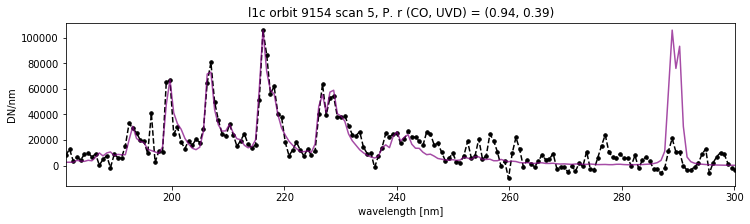

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v17Old\limb_analysis_v17_orbit_9623scan_3.npy


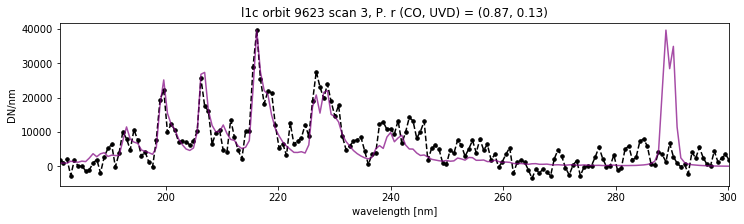

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v20_new\limb_analysis_v20_orbit_10384scan_9.npy


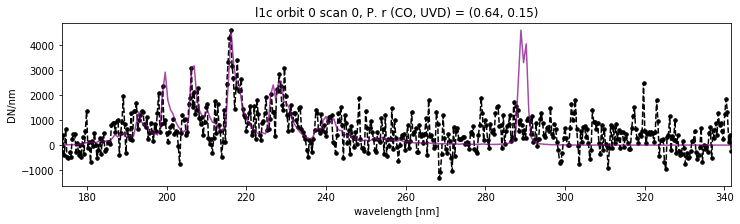

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v20_new\limb_analysis_v20_orbit_10488scan_1.npy


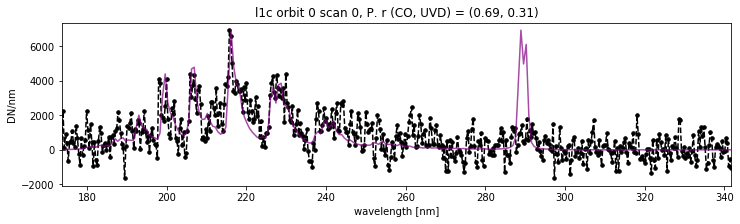

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v20_new\limb_analysis_v20_orbit_10499scan_1.npy


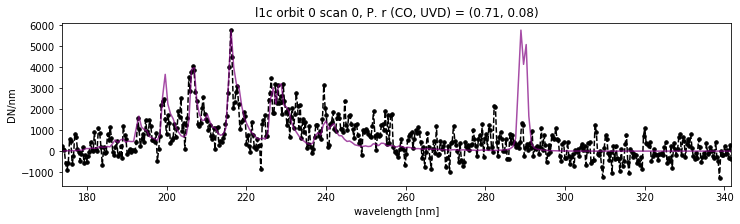

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v20_new\limb_analysis_v20_orbit_10568scan_7.npy


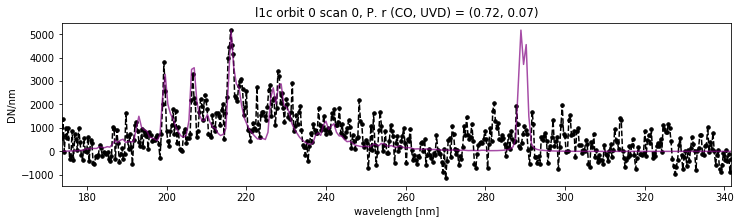

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v20_new\limb_analysis_v20_orbit_10568scan_8.npy


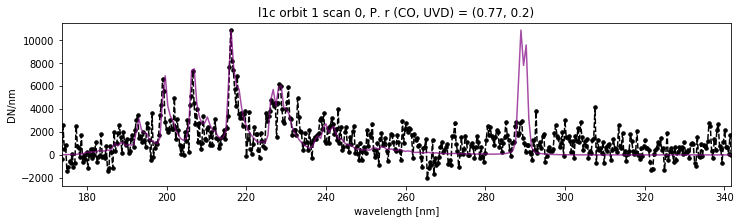

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v20_new\limb_analysis_v20_orbit_10607scan_8.npy


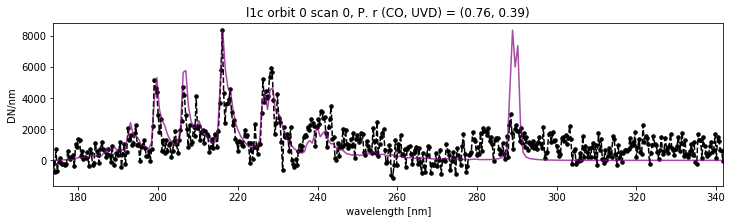

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v20_new\limb_analysis_v20_orbit_10617scan_10.npy


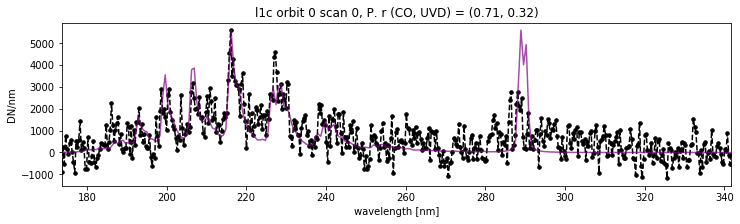

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v20_new\limb_analysis_v20_orbit_8583scan_2.npy


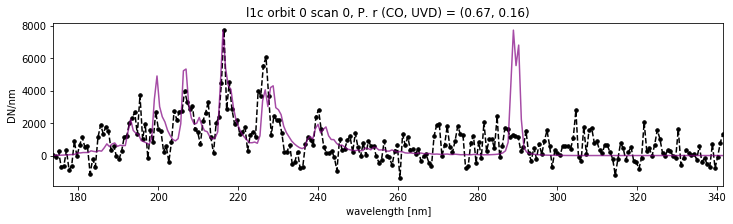

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v20_new\limb_analysis_v20_orbit_8611scan_0.npy


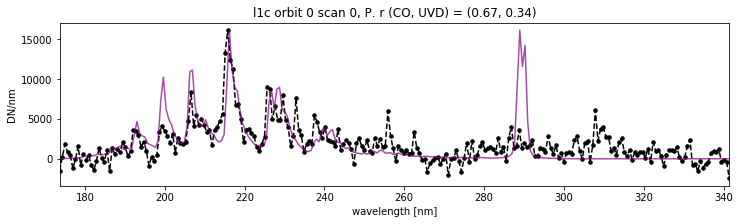

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v20_new\limb_analysis_v20_orbit_8611scan_1.npy


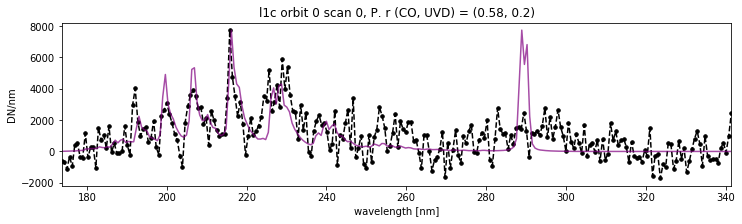

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v20_new\limb_analysis_v20_orbit_8700scan_7.npy


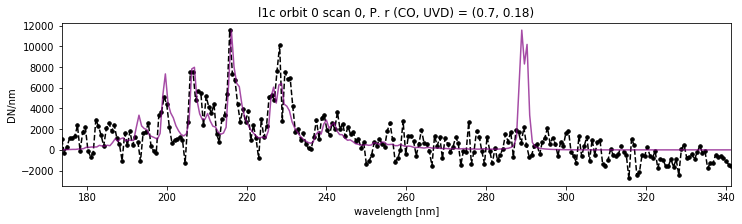

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v20_new\limb_analysis_v20_orbit_8700scan_8.npy


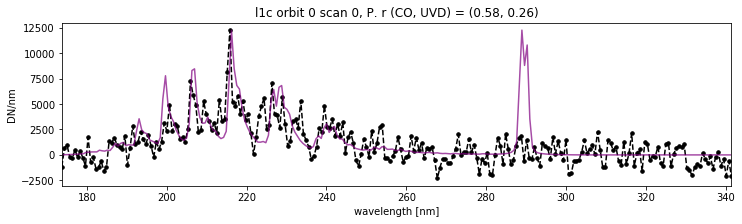

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v20_new\limb_analysis_v20_orbit_9619scan_5.npy


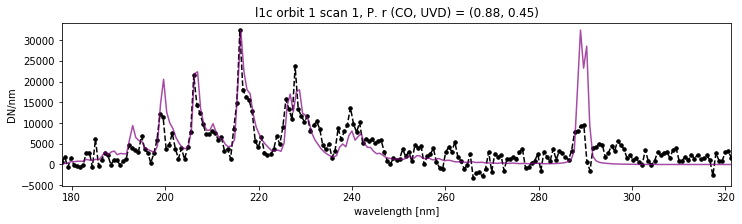

C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v20_new\limb_analysis_v20_orbit_9626scan_6.npy


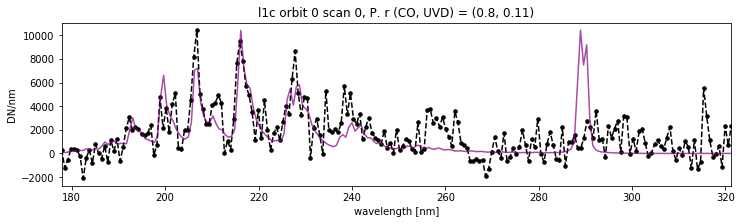

In [19]:
for i in range(len(DN_spectra)):
    print(pixelDataFiles[i])
    plot_spectrum_in_DN_with_templates(DN_wave[i], DN_spectra[i], orbits[i], scans[i], pearsonRs[i])
    plt.show()

In [96]:
def load(orbit,scan):
    spec = np.load(r'C:\Users\Owner\OneDrive - UCB-O365\Documents\College\LASP\MAVEN\code\l1c_Adrienne_v20_final\pixel_npy_files\limb_analysis_v20_orbit_'+str(orbit)+'scan_'+str(scan-1)+'.npy', allow_pickle=True)[3]
    wav = np.load(r'C:\Users\Owner\OneDrive - UCB-O365\Documents\College\LASP\MAVEN\code\l1c_Adrienne_v20_final\pixel_npy_files\limb_analysis_v20_orbit_'+str(orbit)+'scan_'+str(scan-1)+'.npy', allow_pickle=True)[1]
    comlr = np.load(r'C:\Users\Owner\OneDrive - UCB-O365\Documents\College\LASP\MAVEN\code\l1c_Adrienne_v20_final\pixel_npy_files\limb_analysis_v20_orbit_'+str(orbit)+'scan_'+str(scan-1)+'.npy', allow_pickle=True)[10]
    uvdmlr = np.load(r'C:\Users\Owner\OneDrive - UCB-O365\Documents\College\LASP\MAVEN\code\l1c_Adrienne_v20_final\pixel_npy_files\limb_analysis_v20_orbit_'+str(orbit)+'scan_'+str(scan-1)+'.npy', allow_pickle=True)[11]
    return spec,wav, comlr,uvdmlr

In [97]:
ds, dw, dco, duvd = load(8675,3)
ds = ds[11:191]
dw = dw[11:191]+0.4
np.shape(ds)

(180,)

In [99]:
old_npy = np.load(r'C:\Users\Owner\OneDrive - UCB-O365\Documents\College\LASP\MAVEN\code\l1c_Adrienne_v20_final\npy_v17Old\limb_analysis_v17_orbit_2512scan_3.npy', allow_pickle=True)
new_npy = np.load(r'C:\Users\Owner\OneDrive - UCB-O365\Documents\College\LASP\MAVEN\code\l1c_Adrienne_v20_final\npy_v20_new\limb_analysis_v20_orbit_10384scan_9.npy', allow_pickle=True)

In [100]:
old_npy

array([array([173.71267759, 174.04337759, 174.3740776 , 174.7047776 ,
              175.03547761, 175.36617761, 175.69687762, 176.02757762,
              176.35827763, 176.68897763, 177.01967764, 177.35037764,
              177.68107765, 178.01177765, 178.34247766, 178.67317766,
              179.00387767, 179.33457767, 179.66527768, 179.99597768,
              180.32667769, 180.65737769, 180.9880777 , 181.3187777 ,
              181.64947771, 181.98017771, 182.31087772, 182.64157772,
              182.97227773, 183.30297773, 183.63367774, 183.96437774,
              184.29507775, 184.62577775, 184.95647776, 185.28717776,
              185.61787777, 185.94857777, 186.27927778, 186.60997778,
              186.94067779, 187.27137779, 187.6020778 , 187.9327778 ,
              188.26347781, 188.59417781, 188.92487782, 189.25557782,
              189.58627783, 189.91697783, 190.24767783, 190.57837784,
              190.90907784, 191.23977785, 191.57047785, 191.90117786,
              192.23

In [101]:
new_npy

array([array([173.6875    , 174.01642499, 174.34534998, 174.67427497,
              175.00319996, 175.33212495, 175.66104994, 175.98997493,
              176.31889992, 176.64782491, 176.9767499 , 177.30567489,
              177.63459988, 177.96352487, 178.29244986, 178.62137485,
              178.95029984, 179.27922482, 179.60814981, 179.9370748 ,
              180.26599979, 180.59492478, 180.92384977, 181.25277476,
              181.58169975, 181.91062474, 182.23954973, 182.56847472,
              182.89739971, 183.2263247 , 183.55524969, 183.88417468,
              184.21309967, 184.54202466, 184.87094965, 185.19987464,
              185.52879963, 185.85772462, 186.18664961, 186.5155746 ,
              186.84449959, 187.17342458, 187.50234957, 187.83127456,
              188.16019955, 188.48912454, 188.81804953, 189.14697452,
              189.47589951, 189.8048245 , 190.13374949, 190.46267447,
              190.79159946, 191.12052445, 191.44944944, 191.77837443,
              192.10

In [54]:
np.load(r'C:\Users\Owner\OneDrive - UCB-O365\Documents\College\LASP\MAVEN\code\l1c_Adrienne_v20_final\npy_v20_new\limb_analysis_v20_orbit_10384scan_9.npy', allow_pickle=True)[12]

[10384, 9]

In [104]:
for i in range(len(DN_wave)-1):
    if np.shape(DN_wave[i])==(364,):
        new = []
        new2 = []
        cutw = DN_wave[i][1:363]
        cuts = DN_spectra[i][1:363]
        for j in range(1,len(cutw)-1,2):
            val = (cutw[j]+cutw[j-1])/2
            val2 = (cuts[j]+cuts[j-1])/2
            new.append(val)
            new2.append(val2)
        DN_wave[i] = new
        DN_spectra[i] = new2

In [105]:
for i in range(len(DN_wave)):
    DN_wave[i] = np.array(DN_wave[i][0:180])
    DN_spectra[i] = np.array(DN_spectra[i][0:180])

In [102]:
for i in range(len(orbits)):
    print(i,orbits[i],scans[i],ratios[i])

0 2512 2 21.853987397520154
1 2512 3 38.262628336755654
2 2524 0 17.856168172598196
3 2587 3 16.83820662768031
4 2587 5 35.28755537656061
5 2730 6 25.914498141263948
6 3379 10 18.626498002663116
7 3389 11 58.604509973980896
8 3432 11 60.94834148994019
9 3439 7 51.12305025996534
10 3522 9 34.71022222222223
11 3828 6 25.948162533612194
12 3842 8 19.043135095447873
13 3928 10 23.101580135440177
14 401 6 55.40108695652172
15 401 7 66.71954674220964
16 405 7 49.6795466254508
17 408 7 34.039405684754534
18 416 7 13.675879754950847
19 426 7 12.937322611163674
20 426 8 35.66038961038961
21 4403 3 244.98985507246363
22 4557 9 -41.425545171339564
23 4559 3 153.91545893719808
24 4567 10 42.375579598145286
25 4575 8 199.0940594059406
26 4624 7 -24.760238272524195
27 4669 11 -51.450365726227794
28 4684 9 17.152
29 4702 3 52.78233618233619
30 4717 10 22.64132553606238
31 6674 2 -80.48546511627907
32 6711 6 90.3808383233533
33 6753 9 26.203609785202858
34 6762 6 24.098653873026223
35 7802 8 13.138589

In [31]:
#allspec = np.sum(DN_spectra,axis=0)
for i in range(len(DN_wave)):
    print(i,len(DN_wave[i]),orbits[i])

0 364 2512
1 364 2512
2 364 2524
3 181 2587
4 181 2587
5 181 2644
6 181 2730
7 181 3379
8 181 3389
9 181 3432
10 181 3439
11 181 3522
12 181 3828
13 181 3842
14 181 3842
15 364 3928
16 181 401
17 181 401
18 181 405
19 181 408
20 181 416
21 181 426
22 181 426
23 181 4403
24 181 4557
25 181 4559
26 181 4567
27 181 4575
28 181 4624
29 181 4669
30 181 4669
31 181 4684
32 181 4702
33 181 4717
34 181 6674
35 181 6711
36 181 6753
37 364 6762
38 181 7802
39 181 7838
40 181 7876
41 181 7970
42 181 8001
43 181 8018
44 181 8057
45 181 9154
46 181 9623
47 512 0
48 512 0
49 512 0
50 512 1
51 512 0
52 512 0
53 256 0
54 256 0
55 256 0
56 256 0
57 256 0
58 219 0


In [18]:
%matplotlib qt
templates = np.load(r'C:\Users\Owner\OneDrive - UCB-O365\Documents\College\LASP\MAVEN\code\l1c_Adrienne_v20_final\maps_and_data_dir\DN_templates\templates_256_DN.npy', allow_pickle=True)
wav_tmpl0 = templates.item()['wavelength']
co_tmpl0 = templates.item()['co_cameron']
uvd_tmpl0 = templates.item()['co2p_uvd']
no_tmpl0 = templates.item()['no_nightglow']
limits = (6, 191) #index 6 on the 256 wavelength template corresponds to 177.84 nm, index 191 corresponds to 299.54 nm
wav_tmpl_cut = wav_tmpl0[limits[0]:limits[1]] #index out the desired section of the wavelength and CO, NO, and UVD templates
co_tmpl_cut = co_tmpl0[limits[0]:limits[1]]
no_tmpl_cut = no_tmpl0[limits[0]:limits[1]]
uvd_tmpl_cut = uvd_tmpl0[limits[0]:limits[1]]
muv_tmpl_cut2 = (co_tmpl_cut+uvd_tmpl_cut)*np.max(allspec) #Add the CO and UVD templates to show at the same time
#Ask Nick about scaling UVD-should UVD be scaled to the same scale as CO emissions or should it be scaled to the UVD feature
#If so, use the following template instead:
muv_tmpl_cut = co_tmpl_cut*np.max(ds)*3.4 + uvd_tmpl_cut*np.max(ds[140:])*3
#Plot it all
#plt.style.use('dark_background')
plt.figure(figsize=(20,13), dpi=150)
#plt.plot(wav_tmpl_cut, muv_tmpl_cut2, 'r-', label= 'Template')
plt.plot(dw,ds*3.4,'b--',label='Discrete Data')
#plt.plot(wav_tmpl_cut, muv_tmpl_cut, 'r--', label='CO & UVD template',linewidth=2)
plt.plot(DN_wave[0], allspec, color='red', label='47 Anomalous emissions summed',linewidth=1)
plt.hlines(0, xmin=min(dw),xmax=max(dw),linewidth=1)
plt.xlabel('wavelength (nm)',fontsize=20)
plt.ylabel('intensity (DN/nm)',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('47 Anomalous Spectra Summed vs Discrete Emission',fontsize=20)
plt.legend(loc='upper right',fontsize='x-large')
plt.savefig('sumdisc.jpg');

In [107]:
%matplotlib qt
#DN/nm PLOT
fig=plt.figure()
fig.subplots_adjust(hspace=0.0, wspace=0.0)
for i in range(len(DN_wave)-1):
    if DN_wave[i].shape == (364,):
        #use 512 bins
        wav_tmpl_DN, co_tmpl_DN, uvd_tmpl_DN = wav_tmpl512, co_tmpl512, uvd_tmpl512
    else:
        #use 256 bins
        wav_tmpl_DN, co_tmpl_DN, uvd_tmpl_DN = wav_tmpl256, co_tmpl256, uvd_tmpl256
    plt.subplot(8,8,i+1)
    plt.plot(DN_wave[i], DN_spectra[i], c='k',linewidth=0.5)
    if i>40:
        plt.xlabel("wavelength [nm]",fontsize=6)
    if i < 40:
        plt.tick_params(labelbottom=False)
    plt.tick_params(labelleft=False)
    plt.xlim(right=325)
    plt.title(f'{orbits[i]}/{scans[i]}, {pearsonRs[i]},{np.round(ratios[i],1)}',x=0.7,y=0.8,fontsize=7)
    dspecscaled = ds*np.max(DN_spectra[i])/np.max(ds)
    #maxCO = np.max(dspecscaled[:np.where(DN_wave[i] <= 250)[0][-1]])
    #maxUVD = np.max(dspecscaled[np.where(DN_wave[i] >= 275)[0][0]:np.where(DN_wave[i] <= 300)[0][-1]])
    plt.xlim(np.nanmin(DN_wave[i]), np.nanmax(DN_wave[i]))                  
   #plt.plot(wav_tmpl_DN, co_tmpl_DN*maxCO + uvd_tmpl_DN*maxUVD, color='red', alpha=0.7,linewidth=0.5)
    plt.hlines(0,xmin=min(dw),xmax=max(dw),linewidth=0.5,linestyle='dashed')
    #plt.plot(dw,dspecscaled)
#plt.savefig('grid7to1.pdf',format='pdf',bbox_inches='tight')

In [29]:
co_tmpl256kr = np.load(r'C:\Users\Owner\OneDrive - UCB-O365\Documents\College\LASP\MAVEN\code\l1c_Adrienne_v20_final\maps_and_data_dir\kR_templates\co_tmpl_256_kR.npy', allow_pickle= True)
uvd_tmpl256kr = np.load(r'C:\Users\Owner\OneDrive - UCB-O365\Documents\College\LASP\MAVEN\code\l1c_Adrienne_v20_final\maps_and_data_dir\kR_templates\uvd_tmpl_256_kR.npy', allow_pickle= True)           
no_tmpl256kr = np.load(r'C:\Users\Owner\OneDrive - UCB-O365\Documents\College\LASP\MAVEN\code\l1c_Adrienne_v20_final\maps_and_data_dir\kR_templates\no_tmpl_256_kR.npy', allow_pickle= True)
co_tmpl512kr = np.load(r'C:\Users\Owner\OneDrive - UCB-O365\Documents\College\LASP\MAVEN\code\l1c_Adrienne_v20_final\maps_and_data_dir\kR_templates\co_tmpl_512_kR.npy', allow_pickle= True)
uvd_tmpl512kr = np.load(r'C:\Users\Owner\OneDrive - UCB-O365\Documents\College\LASP\MAVEN\code\l1c_Adrienne_v20_final\maps_and_data_dir\kR_templates\uvd_tmpl_512_kR.npy', allow_pickle= True)          
no_tmpl512kr = np.load(r'C:\Users\Owner\OneDrive - UCB-O365\Documents\College\LASP\MAVEN\code\l1c_Adrienne_v20_final\maps_and_data_dir\kR_templates\no_tmpl_512_kR.npy', allow_pickle= True)
wav_tmpl256kr = np.load(r'C:\Users\Owner\OneDrive - UCB-O365\Documents\College\LASP\MAVEN\code\l1c_Adrienne_v20_final\maps_and_data_dir\kR_templates\wav_tmpl_256_kR.npy', allow_pickle=True)

In [30]:
krtmpl = co_tmpl256kr+uvd_tmpl256kr
dntmpl = co_tmpl256+uvd_tmpl256
plt.plot(wav_tmpl_DN,dntmpl)
plt.plot(wav_tmpl256kr,krtmpl, linestyle='dashed');

In [ ]:
co_tmpl256kr = np.load(r'C:\Users\Owner\OneDrive - UCB-O365\Documents\College\LASP\MAVEN\code\l1c_Adrienne_v20_final\maps_and_data_dir\kR_templates\co_tmpl_256_kR.npy', allow_pickle= True)
uvd_tmpl256kr = np.load(r'C:\Users\Owner\OneDrive - UCB-O365\Documents\College\LASP\MAVEN\code\l1c_Adrienne_v20_final\maps_and_data_dir\kR_templates\uvd_tmpl_256_kR.npy', allow_pickle= True)   
krtmpl = co_tmpl256kr+uvd_tmpl256kr
dntmpl = co_tmpl256+uvd_tmpl256

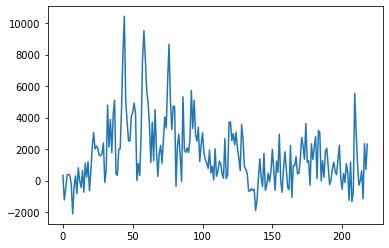

In [26]:
plt.plot(np.load(pixelDataFiles[-1], allow_pickle=True)[3])